In [1]:
#1. import libraries
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#2. bring MNIST dataset
mnist = fetch_openml("mnist_784",parser='auto')

In [3]:
#3. change data type pandas Dataframe to numpy arrays
X, y = mnist.data.values, mnist.target.values

In [4]:
X.shape

(70000, 784)

In [5]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
y

['5', '0', '4', '1', '9', ..., '2', '3', '4', '5', '6']
Length: 70000
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

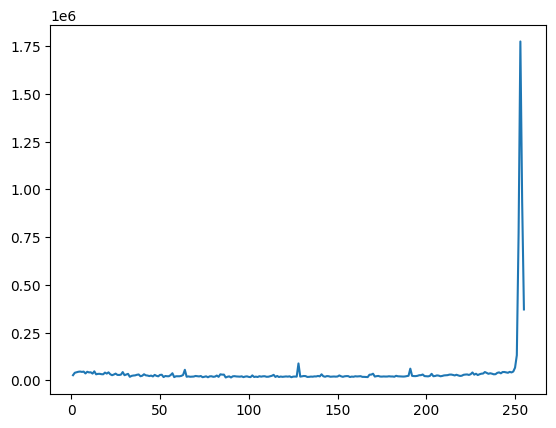

In [8]:
### check pixel value
unique_values, value_count = np.unique(X, return_counts=True)
import matplotlib.pyplot as plt

plt.plot(unique_values[1:], value_count[1:])

# min_pixel_value = np.min(unique_values)
# max_pixel_value = np.max(unique_values)
# min_pixel_value, max_pixel_value

# 값의 분포가 거의 0쪽 아니면 256이기 때문에 베르누이 분포 사용

In [9]:
#4. binarize
X_binary = (X > 128).astype(int)

In [10]:
X_binary[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [11]:
#5. import test, train data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X_binary, y, test_size=0.2)
# 너무 많은 데이터를 테스트 데이터로 하면 과적합. 훈련 중에 보지 못한 데이터가 테스트 데이터이기 때문에 과적합 방지 할 수 있도록 적당한 비율 선택


In [12]:
#6. define a class
class BernoulliNBWithLog:
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        # Calculate and store the log of class priors - the likelihood of each class occurring
        self.class_priors = np.array([np.log(np.mean(y == c)) for c in self.classes])
        
        # Calculate the likelihood of a set of features (the feature vector) given a class
        self.feature_probs = []
        for c in self.classes:
            feature_prob = (X[y == c].sum(axis=0) + 1) / (np.sum(y == c))  # Smoothing with Laplace smoothing
            # Calculate the log of the complement probabilities (1-p) to avoid underflow
            complement_prob = 1 - feature_prob
            self.feature_probs.append((np.log(complement_prob), np.log(feature_prob)))
        self.feature_probs = np.array(self.feature_probs)
        
    def predict(self, X):
        # Calculate the matrix dot product to reflect the relationship between class and features
        # Compute log-likelihoods
        log_likelihoods = np.zeros((X.shape[0], len(self.classes)))
        for i, c in enumerate(self.classes):
            log_likelihoods[:, i] = np.sum(X * self.feature_probs[i][1] + (1 - X) * self.feature_probs[i][0], axis=1)
        
        # Compute log-posteriors
        log_posteriors = log_likelihoods + self.class_priors
        
        predicted_class = self.classes[np.argmax(log_posteriors, axis=1)]
        return predicted_class


In [13]:
#7. Initialize the model
model = BernoulliNBWithLog()

In [20]:
#8. Evaluate the model
accuracies = []
num_iterations = 50

for i in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_binary, y, test_size=0.2, random_state=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate accuracy and append to the list of accuracies
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies) * 100
print("Average Accuracy: {:.2f}%".format(average_accuracy))



Average Accuracy: 83.70%


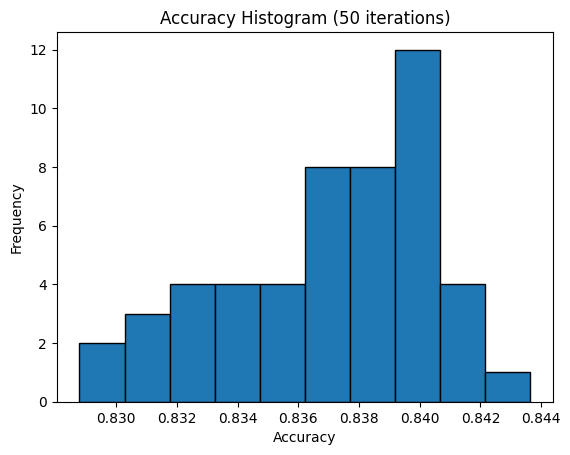

In [21]:
### Visualize. Plot a histogram of the accuracy values
plt.hist(accuracies, bins=10, edgecolor='k')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Histogram ({} iterations)'.format(num_iterations))
plt.show()

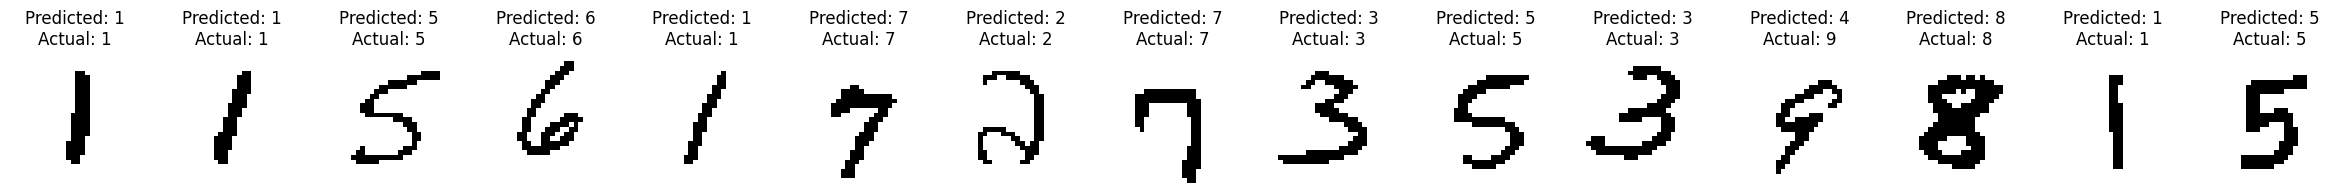

In [24]:
### Visualize. the comparison between predicted and actual labels
import matplotlib.pyplot as plt

num_samples = 15 

fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(X_test[i].reshape(28, 28), cmap='binary', interpolation='nearest')
    ax.set_title(f"Predicted: {y_pred[i]}\nActual: {y_test[i]}")
    ax.axis('off')

plt.show()